The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2023-11-27 23:10:22 INFO  [data.macd_frame:47] SELECT last(best_bid) AS data FROM UNFIUSDT_OrderBookFrame WHERE time >= '2023-11-21 05:10:22.103720' AND time <= '2023-11-28 05:10:22.103740' GROUP BY time(1m)
2023-11-27 23:10:22 DEBUG [exchange_data._database:64] SELECT last(best_bid) AS data FROM UNFIUSDT_OrderBookFrame WHERE time >= '2023-11-21 05:10:22.103720' AND time <= '2023-11-28 05:10:22.103740' GROUP BY time(1m)
2023-11-27 23:10:22 INFO  [data.macd_frame:62]                             price
time                             
2023-11-21 05:10:00+00:00   9.576
2023-11-21 05:11:00+00:00   9.580
2023-11-21 05:12:00+00:00   9.582
2023-11-21 05:13:00+00:00   9.598
2023-11-21 05:14:00+00:00   9.590
...                           ...
2023-11-28 05:06:00+00:00  11.753
2023-11-28 05:07:00+00:00  11.771
2023-11-28 05:08:00+00:00  11.762
2023-11-28 05:09:00+00:00  11.781
2023-11-28 05:10:00+00:00  11.787

[10081 rows x 1 columns]
2023-11-27 23:10:22 DEBUG [ipykernel_2989871.2704649463:83] [

                             open    high     low   close  macd_diff  trade  \
time                                                                          
2023-11-21 05:00:00+00:00   9.576   9.598   9.576   9.590   0.000000      0   
2023-11-21 05:15:00+00:00   9.584   9.584   9.545   9.557   0.000000      1   
2023-11-21 05:30:00+00:00   9.559   9.566   9.515   9.557   0.000000      1   
2023-11-21 05:45:00+00:00   9.567   9.577   9.552   9.552   0.000000      1   
2023-11-21 06:00:00+00:00   9.550   9.554   9.505   9.532   0.000000      1   
...                           ...     ...     ...     ...        ...    ...   
2023-11-28 04:00:00+00:00  11.609  11.675  11.557  11.557  -0.014906      1   
2023-11-28 04:15:00+00:00  11.550  11.603  11.465  11.519  -0.013582      1   
2023-11-28 04:30:00+00:00  11.510  11.720  11.426  11.719   0.002400      0   
2023-11-28 04:45:00+00:00  11.749  11.758  11.716  11.742   0.015432      1   
2023-11-28 05:00:00+00:00  11.719  11.787  11.719  1

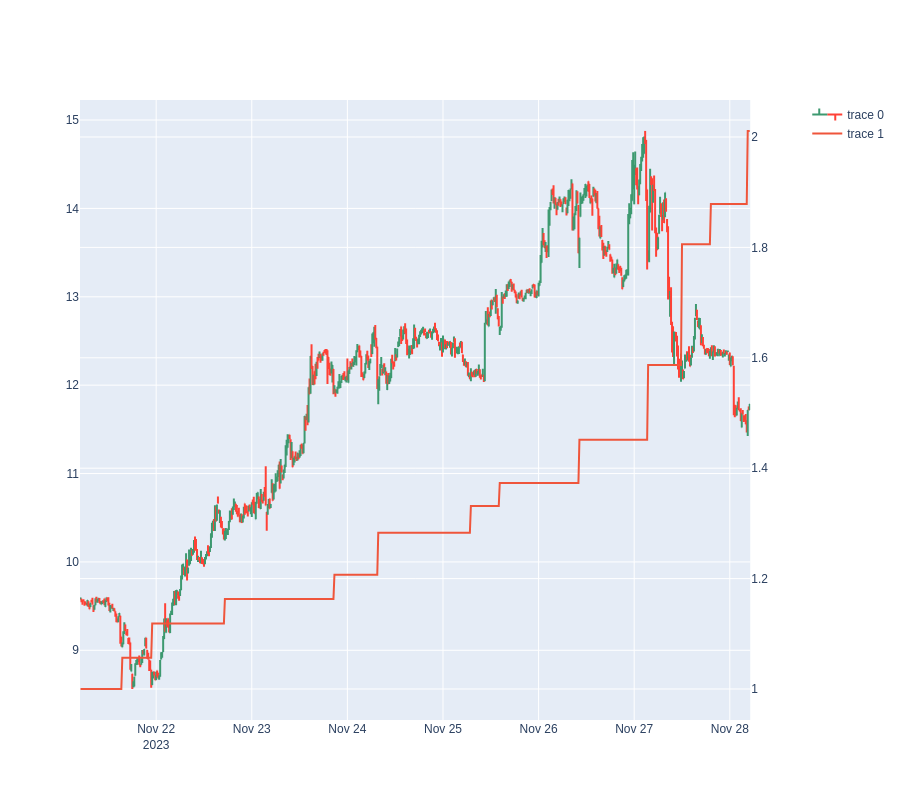

In [19]:
%load_ext autoreload
%autoreload 2

from exchange_data.data.macd_frame import MacdFrame
import pandas as pd
import numpy as np
import alog
import plotly.graph_objs as go
import plotly.express as px
import plotly as py
import plotly.offline as ofl
from plotly.offline import init_notebook_mode
import plotly.graph_objects as go
from plotly.subplots import make_subplots

init_notebook_mode(connected=True)
params = {
 'database_name': 'binance_futures',
 'futures': False,
 'group_by': '1m',
 'interval': '7d',
 'offset_interval': '0h',
 'symbol': 'UNFIUSDT'
}

df = MacdFrame(**params).frame

#pd.set_option("display.max_rows", len(df) + 1)

from scipy.signal import argrelextrema
n = 6

min = argrelextrema(df['open'].to_numpy(), np.less_equal, order=n)[0]
max = argrelextrema(df['open'].to_numpy(), np.greater_equal, order=n)[0]
position = []
active_trade = False

for ix in range(0, df.shape[0]):
    if ix in max:
        active_trade=True
    if ix in min:
        active_trade=False
        
    if active_trade:
        position.append(1)
    else:
        position.append(0)

df['trade'] = position

capital = 1
df['capital'] = 0
df_len = df.shape[0]
capital_ls = []
price_in = None
ix_in = None
ix_out = None
trades = []

for ix in range(0, df_len):
    if ix < df_len - 1:
        row = df.iloc[ix]
        next_row = df.iloc[ix + 1]
        best_ask = row['open']
        
        if row['trade'] == 1:
            if price_in == None:
                price_in = best_ask
                ix_in = ix
        else:
            if price_in:
                ix_out = ix
                pnl = (price_in - best_ask) / price_in
                if pnl > 0.03:
                    capital = capital + (capital * pnl)    
                    trades.append((ix_in, ix_out, pnl))
                
            price_in = None
            
    #alog.info(capital)
    capital_ls.append(capital)

alog.debug(trades)
alog.debug(len(trades))
df['capital'] = np.asarray(capital_ls)

print(df)

fig1 = go.Ohlc(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])

fig2 = go.Line(
    x=df.index,
    y=df['capital'],
    yaxis='y2'
)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(fig1)
fig.add_trace(fig2,secondary_y=True)
fig.update_layout(height=800)
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()